In [18]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

np.random.seed(37)

In [19]:
import itertools

indexes = list(itertools.product([0,1,2,3,4,5,6,7],[0,1,2],[0,1,2]))
print(indexes)

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 2, 0), (0, 2, 1), (0, 2, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 2, 0), (1, 2, 1), (1, 2, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 2, 0), (2, 2, 1), (2, 2, 2), (3, 0, 0), (3, 0, 1), (3, 0, 2), (3, 1, 0), (3, 1, 1), (3, 1, 2), (3, 2, 0), (3, 2, 1), (3, 2, 2), (4, 0, 0), (4, 0, 1), (4, 0, 2), (4, 1, 0), (4, 1, 1), (4, 1, 2), (4, 2, 0), (4, 2, 1), (4, 2, 2), (5, 0, 0), (5, 0, 1), (5, 0, 2), (5, 1, 0), (5, 1, 1), (5, 1, 2), (5, 2, 0), (5, 2, 1), (5, 2, 2), (6, 0, 0), (6, 0, 1), (6, 0, 2), (6, 1, 0), (6, 1, 1), (6, 1, 2), (6, 2, 0), (6, 2, 1), (6, 2, 2), (7, 0, 0), (7, 0, 1), (7, 0, 2), (7, 1, 0), (7, 1, 1), (7, 1, 2), (7, 2, 0), (7, 2, 1), (7, 2, 2)]


In [20]:
def normalize(values, bounds):
    return [bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]

In [21]:
def get_F(h, s, v):
    h_norm = normalize(
        h,
        {'actual': {'lower': 0, 'upper': 179}, 'desired': {'lower': 0, 'upper': 360}}
    )
    s_norm = normalize(
        s,
        {'actual': {'lower': 0, 'upper': 255}, 'desired': {'lower': 0, 'upper': 1}}
    )
    v_norm = normalize(
        v,
        {'actual': {'lower': 0, 'upper': 255}, 'desired': {'lower': 0, 'upper': 1}}
    )
    
    h_norm = np.array(h_norm).flatten()
    s_norm = np.array(s_norm).flatten()
    v_norm = np.array(v_norm).flatten()
    
    h_d = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0}
    s_d = {0:0, 1:0, 2:0}
    v_d = {0:0, 1:0, 2:0}

    for i in range(len(h_norm)):
        H = h_norm[i]
        ha = None
        if H >= 316 or H <= 20:
            ha = 0
        elif H >= 21 and H <= 40:
            ha = 1
        elif H >= 41 and H <= 75:
            ha = 2
        elif H >= 76 and H <= 155:
            ha = 3
        elif H >= 156 and H <= 190:
            ha = 4
        elif H >= 191 and H <= 270:
            ha = 5
        elif H >= 271 and H <= 295:
            ha = 6
        elif H >= 296 and H <= 315:
            ha = 7
        if ha not in h_d:
            h_d[ha] = 1
        else:
            h_d[ha] += 1

    for i in range(len(s_norm)):
        S = s_norm[i]
        sa = None
        if S >= 0 and S <= 0.2:
            sa = 0
        elif S > 0.2 and S <= 0.7:
            sa = 1
        elif S > 0.7 and S <= 1:
            sa = 2
        if sa not in s_d:
            s_d[sa] = 1
        else:
            s_d[sa] += 1

    for i in range(len(v_norm)):
        V = v_norm[i]
        va = None
        if V >= 0 and V <= 0.2:
            va = 0
        elif V > 0.2 and V <= 0.7:
            va = 1
        elif V > 0.7 and V <= 1:
            va = 2
        if va not in v_d:
            v_d[va] = 1
        else:
            v_d[va] += 1
            
    F = np.zeros((72,))
    
    for i in range(8):
        for j in range(3):
            for k in range(3):
                F[indexes.index((i, j, k))] = 9*h_d[i] + 3*s_d[j] + v_d[k]
    return F

In [22]:
def process_video(fname):
    vidcap = cv2.VideoCapture(fname)
    success, img = vidcap.read()

    #print(success)

    count = 0
    while success:
        #cv2.imwrite(out_path+"frame%d.jpg" % count, image)     # save frame as JPEG file
        img2 = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = img2[:,:,0], img2[:,:,1], img2[:,:,2]
        F = get_F(h, s, v)
        #print(F)
        colour_features.append(F)
        if(count%10 == 0):
            print("{count} images done".format(count=count))
        success, img = vidcap.read()
        #print('Read a new frame: ', success)
        count += 1
        
    best_i = 0
    best_sc = -1

    for i in range(3,21):
        kmeans = KMeans(n_clusters=i, random_state=0).fit(colour_features)
        sc = silhouette_score(colour_features, kmeans.labels_)
        if(sc > best_sc):
            best_i = i
            best_sc = sc
        print(i, silhouette_score(colour_features, kmeans.labels_))

    kmeans = KMeans(n_clusters=best_i, random_state=0).fit(colour_features)
    cents = kmeans.cluster_centers_

    print(len(colour_features), len(kmeans.labels_))

    min_dict = {}
    min_frame= {}
    for i in range(len(kmeans.labels_)):
        t = np.linalg.norm(colour_features[i]-cents[kmeans.labels_[i]])
        if kmeans.labels_[i] not in min_dict:
            min_dict[kmeans.labels_[i]] = t
            min_frame[kmeans.labels_[i]] = i
        else:
            if(t < min_dict[kmeans.labels_[i]]):
                min_dict[kmeans.labels_[i]] = t
                min_frame[kmeans.labels_[i]] = i

    print(min_frame)

    key_frames = list(min_frame.values())

    count = 0

    cur_dir = fname[0:-4]
    print(cur_dir)
    os.mkdir(cur_dir)

    vidcap = cv2.VideoCapture(fname)
    success, img = vidcap.read()
    print('Read a new frame: ', success)

    while success:
        if count in key_frames:
            print(cur_dir + "\\" + str(count) + ".jpg")
            cv2.imwrite(cur_dir + "\\" + str(count) + ".jpg", img)
            plt.imshow(img)
            plt.show()
        success, img = vidcap.read()
        #print('Read a new frame: ', success)
        count += 1

C:\Users\Souvik\Desktop\Testing\MVI_5183.MOV
0 images done
10 images done
20 images done
30 images done
40 images done
50 images done
60 images done
70 images done
3 0.29388867598951873
4 0.29593080294610447
5 0.29897122731123765
6 0.26630801552453287
7 0.2627771906228705
8 0.2506778783397848
9 0.2686395755223436
10 0.26462817528507415
11 0.2912451192972825
12 0.293027329164864
13 0.2667976675396977
14 0.24553443098519362
15 0.2678463570211438
16 0.2600172762136621
17 0.24417451210124583
18 0.254423825361093
19 0.2484128199228658
20 0.2305131918838752
71 71
{4: 28, 2: 3, 3: 7, 1: 53, 0: 66}
C:\Users\Souvik\Desktop\Testing\MVI_5183
Read a new frame:  True
C:\Users\Souvik\Desktop\Testing\MVI_5183\3.jpg


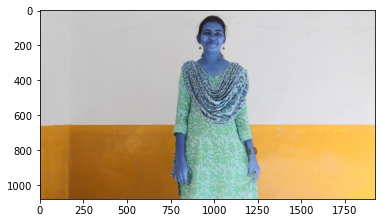

C:\Users\Souvik\Desktop\Testing\MVI_5183\7.jpg


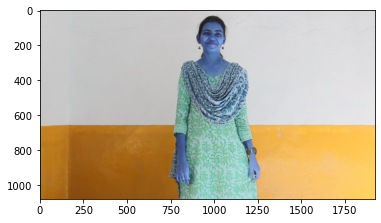

C:\Users\Souvik\Desktop\Testing\MVI_5183\28.jpg


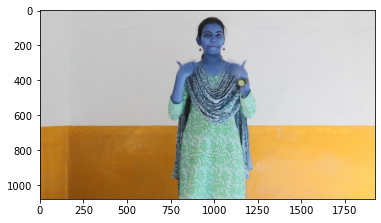

C:\Users\Souvik\Desktop\Testing\MVI_5183\53.jpg


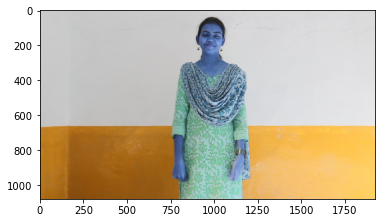

C:\Users\Souvik\Desktop\Testing\MVI_5183\66.jpg


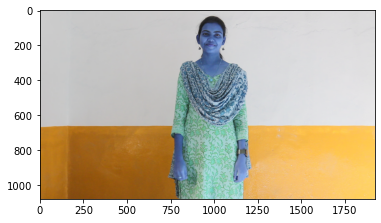

C:\Users\Souvik\Desktop\Testing\MVI_9565.MOV
0 images done
10 images done
20 images done
30 images done
40 images done
50 images done
60 images done
3 0.6716651803041931
4 0.6195198302251457
5 0.620570528628693
6 0.6298989849583223
7 0.5280218655396743
8 0.5058705446806081
9 0.5134942072469638
10 0.5071819106767059
11 0.5121248064817261
12 0.2853381377866767
13 0.2950701682268729
14 0.3005338553776001
15 0.28229020469180577
16 0.30663387184366775
17 0.28838091131555016
18 0.3211155861617747
19 0.295172644890586
20 0.26468082242159063
134 134
{0: 35, 2: 5, 1: 105}
C:\Users\Souvik\Desktop\Testing\MVI_9565
Read a new frame:  True
C:\Users\Souvik\Desktop\Testing\MVI_9565\5.jpg


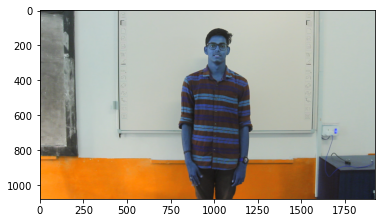

C:\Users\Souvik\Desktop\Testing\MVI_9565\35.jpg


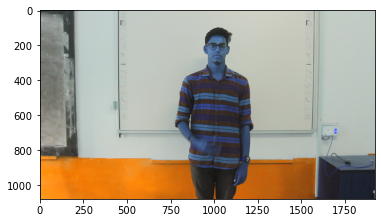

C:\Users\Souvik\Desktop\Testing\MVI_9569.MOV
0 images done
10 images done
20 images done
30 images done
40 images done
50 images done
60 images done
3 0.7887968408521935
4 0.584221347207562
5 0.5592578334817029
6 0.5588710397007591
7 0.5531903250948424
8 0.4516000108336342
9 0.4578760840431889
10 0.44079074730219814
11 0.4425365135142279
12 0.43809666973579364
13 0.4333353456293218
14 0.31363258027374186
15 0.3050404288226462
16 0.3082423580647488
17 0.30698752827680714
18 0.31329174885180255
19 0.30988607097118814
20 0.3016185907743462
199 199
{1: 35, 2: 105, 0: 175}
C:\Users\Souvik\Desktop\Testing\MVI_9569
Read a new frame:  True
C:\Users\Souvik\Desktop\Testing\MVI_9569\35.jpg


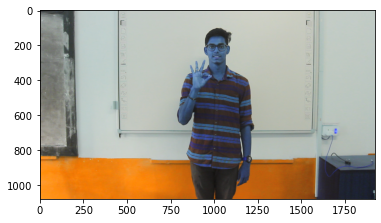

In [23]:
import os
from os import listdir

colour_features = []
count = 0

import cv2
for root, dirs, files in os.walk("C:\\Users\\Souvik\\Desktop\\Testing", topdown=False):
    for name in files:
        print(os.path.join(root, name))
        process_video(os.path.join(root, name))